<a href="https://colab.research.google.com/github/DZhang3210/A-pathfiding/blob/main/Tabular%20Data%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [38]:
import torch # Torch main framework
import torch.nn as nn # Used for getting the NN Layers
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

In [39]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [40]:
data_df.dropna(inplace = True)
data_df.drop(['id'], axis=1, inplace = True)
print(data_df.shape)

(18185, 11)


In [41]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [42]:
print(data_df["Class"].unique())

[1 0]


In [43]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [44]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [45]:
X = np.array(data_df.iloc[:, :-1])
Y = np.array(data_df.iloc[:, -1])

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3)

In [47]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size = 0.5)

In [48]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [94]:
#Tensors specifically must be specified to a device type in order to facilitate
#proper parallel processing
#lower case "t" tensor infers the data type from input
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [54]:
training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test, Y_test)

In [79]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 32, shuffle = True)


In [57]:
HIDDEN_NEURONS = 10

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)


In [58]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [63]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [80]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs, labels= data

    prediction = model(inputs).squeeze(1)
    # Comparing 1D array instead of 2D Array
    # print(prediction.shape)
    # print(prediction.squeeze(1).shape)
    # torch.Size([8, 1])
    # torch.Size([8])

    batch_loss = criterion(prediction, labels)
    #.item() converts from Tensor to relevant integer
    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)

      total_loss_val += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/len(training_data) * 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/len(validation_data) * 100, 4))

  #''' Is for multi-line print statement, and f is for easy insertions
  print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/len(training_data) * 100, 4)}
        Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/len(validation_data) * 100, 4)}''')
  print("="*25)

Epoch no. 1 Train Loss: 0.0162 Train Accuracy: 98.6723
        Validation Loss: 0.0035 Validation Accuracy: 98.827
Epoch no. 2 Train Loss: 0.0163 Train Accuracy: 98.6173
        Validation Loss: 0.0034 Validation Accuracy: 98.8636
Epoch no. 3 Train Loss: 0.0163 Train Accuracy: 98.6252
        Validation Loss: 0.0033 Validation Accuracy: 98.8636
Epoch no. 4 Train Loss: 0.0163 Train Accuracy: 98.6959
        Validation Loss: 0.0033 Validation Accuracy: 98.8636
Epoch no. 5 Train Loss: 0.0166 Train Accuracy: 98.5623
        Validation Loss: 0.0034 Validation Accuracy: 98.8636
Epoch no. 6 Train Loss: 0.0165 Train Accuracy: 98.6095
        Validation Loss: 0.0034 Validation Accuracy: 98.8636
Epoch no. 7 Train Loss: 0.0162 Train Accuracy: 98.6409
        Validation Loss: 0.0034 Validation Accuracy: 98.8636
Epoch no. 8 Train Loss: 0.0163 Train Accuracy: 98.7116
        Validation Loss: 0.0035 Validation Accuracy: 98.827
Epoch no. 9 Train Loss: 0.0164 Train Accuracy: 98.6016
        Validation 

In [81]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in testing_dataloader:
    inputs, label = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, label).item()

    total_loss_test += batch_loss_test
    acc = ((prediction).round() == label).sum().item()
    total_acc_test += acc

  print("Accuracy", round(total_acc_test/len(testing_data) * 100, 4))

Accuracy 98.6437


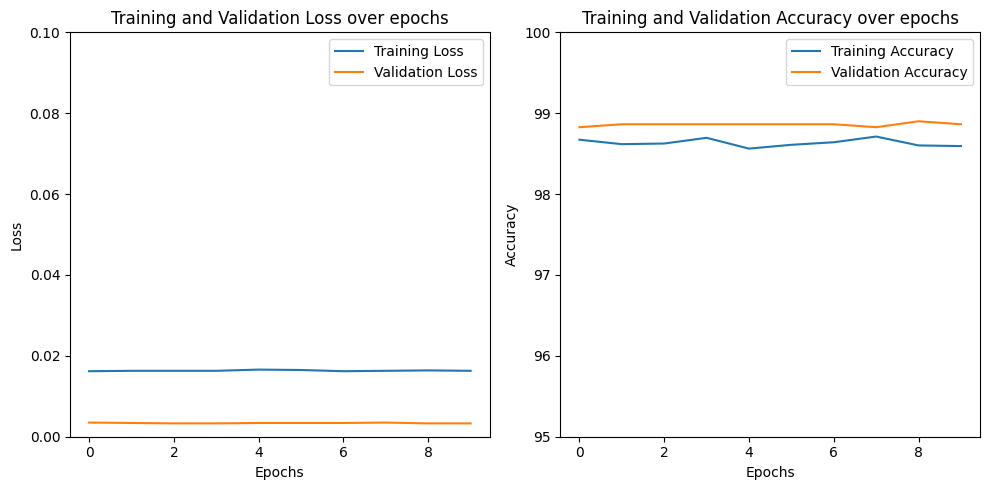

In [99]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,0.1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([95,100])
axs[1].legend()

plt.tight_layout()

plt.show()


In [93]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
#"T" Tensor always generates a float tensor
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

KeyboardInterrupt: Interrupted by user